In [42]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import spacy as sp
import en_core_web_sm
import string

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from preprocess.preprocess import TextPreprocessor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost.sklearn import XGBClassifier 

from IPython.display import Image

import pickle

### Load the Data

In [13]:
#Read both datasets and set labels to relevant and irrelevant
relevant = pd.read_json('../../data/raw/relevant_news_10K.json');
relevant['index'] = relevant.index
relevant['label']=1
irrelevant = pd.read_json('../../data/raw/irrelevant_news_10K.json')
irrelevant['index']=irrelevant.index
irrelevant['label']=0

In [14]:
data = pd.concat([relevant,irrelevant])

In [15]:
X = data.content

In [16]:
ylabels = data.label

#### Split into test and train

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2,random_state = 42)

### Wrapper class for cleaning and vectorizing the data

In [18]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = en_core_web_sm.load()
stop_words = sp.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [19]:
#initialize the bag of words vectorizer
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [20]:
#Class to clean and vectorize any input data
class cleanbow:
    def fit_transform(data):
        interim = TextPreprocessor(n_jobs=10).transform(pd.Series(data)) #TextPreprocessor cleans the data
        return bow_vector.fit_transform(interim) #returns vector
    
    def transform(data):
        
        interim = TextPreprocessor(n_jobs=10).transform(pd.Series(data)) #TextPfreprocessor cleans the data
        return bow_vector.transform(interim) #returns vector
    

In [21]:
vectorizer = cleanbow #instantiate the vectorizer and cleaning class

In [22]:
#Clean and vectorize the data
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

### Importing pre-trained XGBoost model

In [26]:
xclas = pickle.load(open("../../models/best_bow_xgboost_model.sav", 'rb'))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Explanation model

In [27]:
#Import LIME
import lime
from lime import lime_text

#Set class names to irrelevant and relevant for easy readability
class_names = ["irrelevant","relevant"]

#Import the text explainer
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [28]:
#Make a pipeline of the vectorizer and the model
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, xclas)

In [29]:
#Reset X_test index so we can access test data using a random id
X_test = X_test.reset_index()
del X_test['index']

In [30]:
#Generate a random id
idx = np.random.random_integers(low=0,high=4000)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  


In [ ]:
#Now we generate an explainer with a random test point, the prediction probability function of the pipeline, 
#and we set num_features to 20 to get the top 20 weighted words
exp = explainer.explain_instance(X_test.content[idx], c.predict_proba, num_features=20)

In [ ]:
#Let's crosscheck if our current random document was correctly classified
print('Document id: %d' % idx)
print('Probability(relevant) =', c.predict_proba(X_test.content[idx])[0,1])
print('True class: %s' % class_names[y_test[idx]])

In [ ]:
#Now when we view the list of top weighted words, 
#we see that the high negative weights imply higher 
#irrelevancy and high positive weights imply higher relevancy
exp.as_list()

In [ ]:
#Graphically we can view that as
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
#For a clearer picture we can view which words are weighted as more relevant 
#in context by viewing the highlighted words in the article
exp.show_in_notebook(text=True)

### The outputs from lime allow a user to see in cintext the words that are more relevantly weighted and more irrelevantly weighted

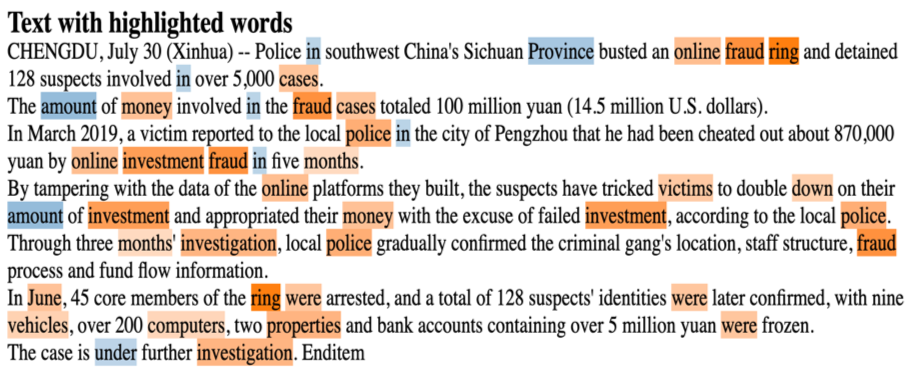

In [44]:
Image(filename='../../docs/images/Results.png') 

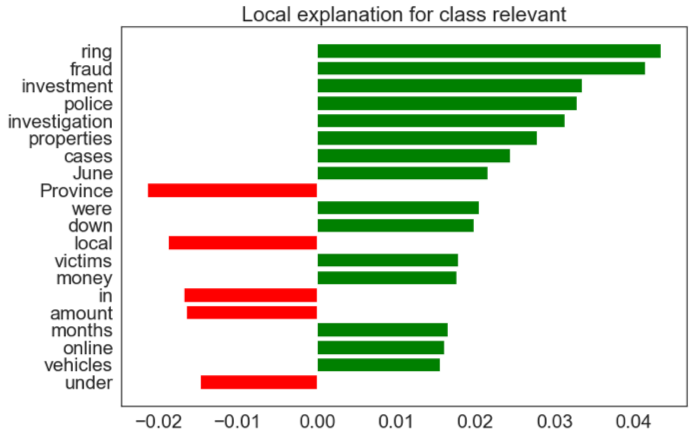

In [45]:
Image(filename='../../docs/images/Results2.png')

# Generating insights
### We're now going to see the frequency of words that are more frequently relevant and more frequently irrelevant

In [91]:
d = []


for i in range(100):
    if i%10 == 0:
        print("Completed ", i, "% of the task")
    #for 100 random samples we generate the top 20 weighted words
    idx = np.random.random_integers(low=0,high=4000)
    exp = explainer.explain_instance(X_test.content[idx], c.predict_proba, num_features=20)
    #for each word if the weight is positive the relevant column is set to one
    #else irrelevant column is set to one
    for e in exp.as_list():
        if e[1] >= 0:
            #print("relevant")
            d.append([e[0],1,0])
        else:
            #print("irrelevant")
            d.append([e[0],0,1])


0


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

10


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

20


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

30


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

40


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

50


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

60


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

70


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

80


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

90


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 4000 + 1) instead
 

### The insights dataframe now consists of every word that was in the top 20 features for 100 random articles, marked as weighted relevant or irrelevant

In [107]:
insights = pd.DataFrame(data=d,columns=["words","relevant","irrelevant"])

In [110]:
insights["words"] = insights["words"].str.lower() #Set all words to lower, to account for same words in different cases

In [111]:
insights.describe()

,relevant,irrelevant
count,2000.00000,2000.00000
mean,0.71250,0.28750
std,0.45271,0.45271
min,0.00000,0.00000
25%,0.00000,0.00000
50%,1.00000,0.00000
75%,1.00000,1.00000
max,1.00000,1.00000


In [112]:
insights = insights.groupby("words",as_index=False).sum() # Group by words and total up the 
                                                        #relevant and irrelevant occurances

In [113]:
#Generate words thata re mostly relevant and irrelevant by finding the difference of the number of times a 
#word was classified as relevant and the number of times it was classified as irrelevant

insights["diff"] = insights["relevant"] - insights["irrelevant"]                                                                    

### Now we can plot the top 20 relevant and irrelevant words:

In [114]:
rel = insights.sort_values(by="diff",ascending=False).head(20) #get top 20 relevant words

In [115]:
irrel = insights.sort_values(by="diff",ascending=True).head(20) # get top 20 irrelevant words

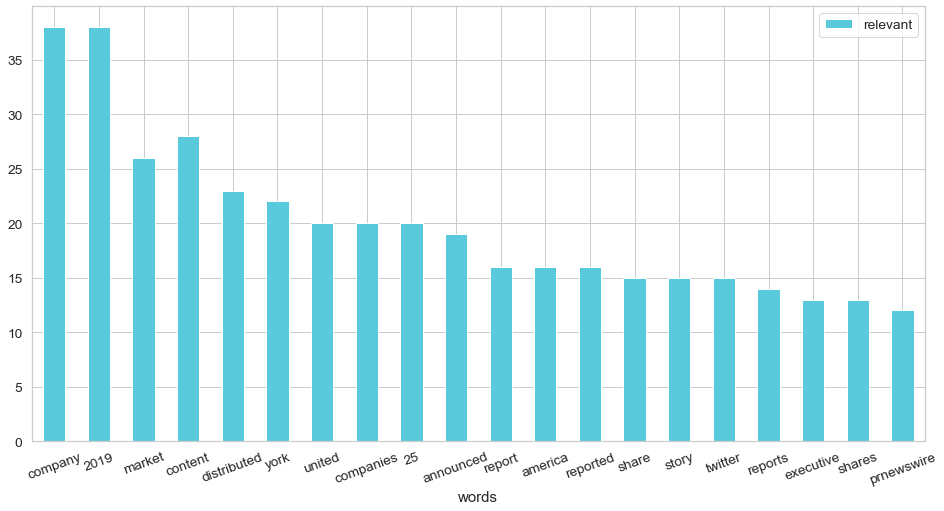

In [136]:
import seaborn as sns


sns.set(font_scale=1.25)
sns.set_style("whitegrid")
rel.plot.bar(x='words', y='relevant',figsize=(16,8), rot=20, color=(0.34901960784313724, 0.792156862745098, 0.8588235294117647))

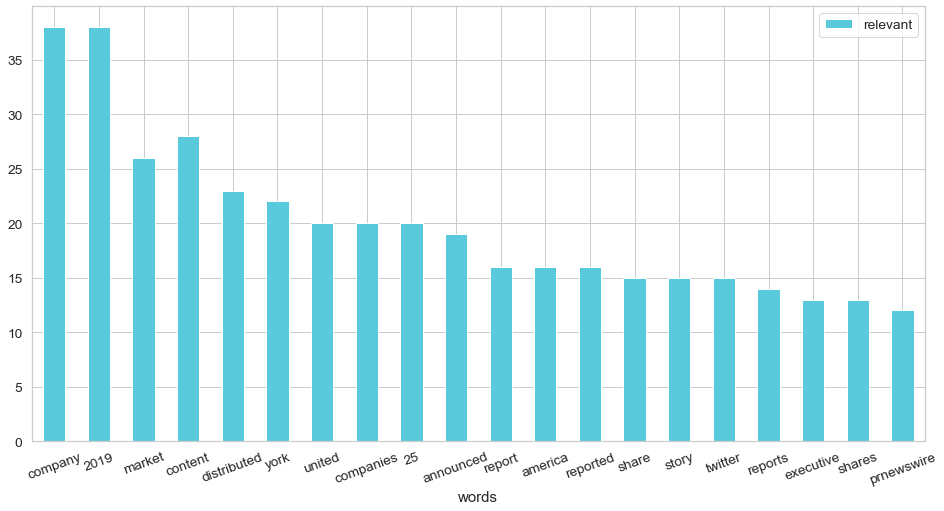

In [47]:
Image(filename="../../docs/images/iteration-2rel.png")

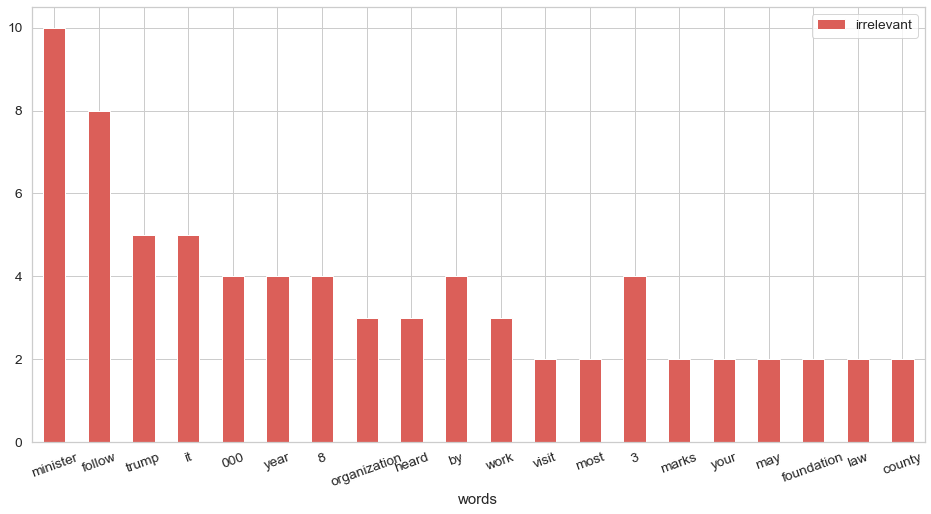

In [137]:
irrel.plot.bar(x='words', y='irrelevant',figsize=(16,8), color = (0.8588235294117647, 0.37254901960784315, 0.34901960784313724),rot=20)

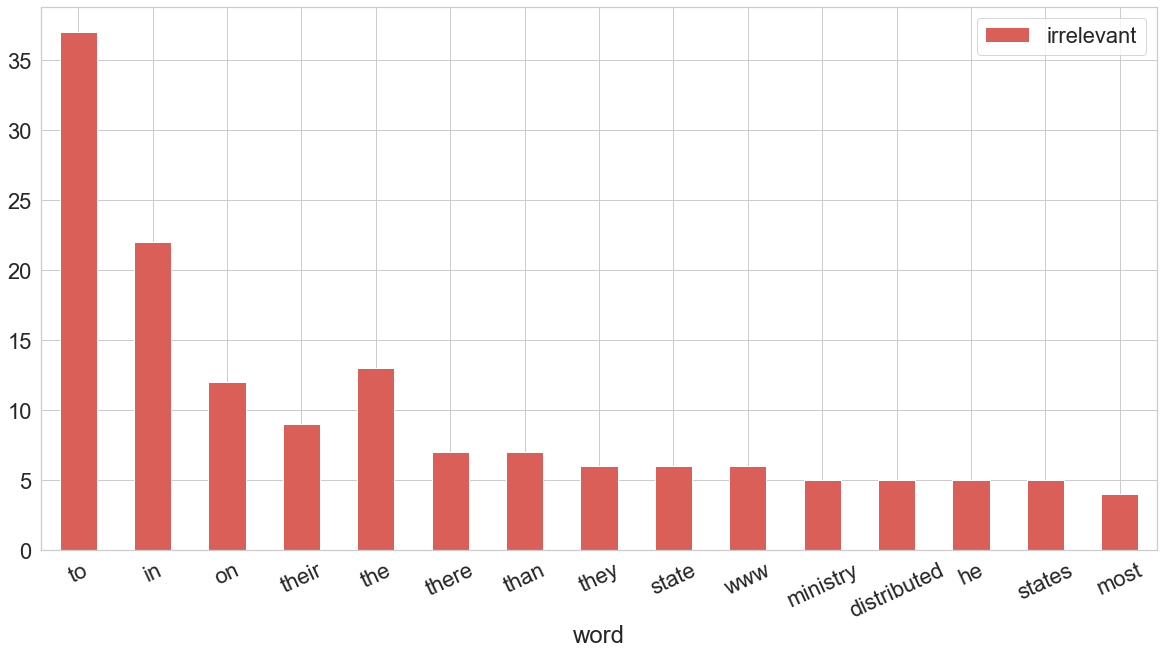

In [48]:
Image(filename="../../docs/images/iteration-1irrel.png")